# Analyze data using ilastik
The notebook shows how load images contained in a dataset
from OMERO as numpy arrays and analyze them in ilastik.
It assumes that ilastik project is linked to the dataset.
Binary data are read from S3.
The order might need to be adjusted depending on the ilastik project.

### Insert required packages

In [1]:
import numpy
import os
import itertools
import zarr
import dask.array as da
import s3fs

import tempfile

import omero.clients
from omero.gateway import BlitzGateway
from getpass import getpass
from collections import OrderedDict

from collections import OrderedDict
import ilastik_main
from ilastik.applets.dataSelection import DatasetInfo
from ilastik.applets.dataSelection.opDataSelection import PreloadedArrayDatasetInfo
import ipywidgets as widgets
# package for 3d visualization
from itkwidgets import view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

### Create a connection to an OMERO server

In [2]:
HOST = 'wss://outreach.openmicroscopy.org/omero-ws'
conn = BlitzGateway(input("Username: "),
                    getpass("OMERO Password: "),
                    host=HOST, secure=True)
conn.connect()

Username: trainer-1
OMERO Password: ········


True

### Enter the dataset ID

In [3]:
dataset_id = 6161

### Load the ilastik projects linked to the dataset

In [4]:
def load_model(dataset_id, path):
    dataset = conn.getObject("Dataset", dataset_id)
    # Go through all the annotations on the Dataset
    options = []
    for ann in dataset.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            name = ann.getFile().getName()
            # Select the ilatisk project TODO: use namespace
            if name.endswith(".ilp"):
                file_path = os.path.join(path, name)
                options.append((name, file_path))
                with open(str(file_path), 'wb') as f:
                    for chunk in ann.getFileInChunks():
                        f.write(chunk)
    return widgets.Dropdown(options=options, disabled=False)

### Helper function: load an Image as 5D-numpy array: order TZYXC

In [5]:
def load_from_s3(image, resolution='0'):
    cache_size_mb = 2048
    # ID to be changed
    id = image.getId()
    cfg = {
        'anon': True,
        'client_kwargs': {
            'endpoint_url': 'https://minio-dev.openmicroscopy.org/',
        },
        'root': 'idr/outreach/%s.zarr' % id
    }
    s3 = s3fs.S3FileSystem(
        anon=cfg['anon'],
        client_kwargs=cfg['client_kwargs'],
    )
    store = s3fs.S3Map(root=cfg['root'], s3=s3, check=False)
    cached_store = zarr.LRUStoreCache(store, max_size=(cache_size_mb * 2**20))
    # data.shape is (t, c, z, y, x) by convention
    data = da.from_zarr(cached_store)
    values = data[:]
    values = values.swapaxes(1, 2).swapaxes(2, 3).swapaxes(3, 4)
    return numpy.asarray(values)

In [6]:
def load_data(image, path, extension=".zip", resolution=0):
    # load annotation linked to the image. Download in a tmp dir
    for ann in image.listAnnotations():
        if isinstance(ann, omero.gateway.FileAnnotationWrapper):
            name = ann.getFile().getName()
            ns = ann.getNs()
            if (name.endswith(".zip") or  name.endswith(".tar")):
                file_path = os.path.join(path, name)
                f_path = os.path.join(path, name.strip(extension))
                with open(str(file_path), 'wb') as f:
                    for chunk in ann.getFileInChunks():
                        f.write(chunk)
                # extract the file
                if extension == ".tar":
                    tf = tarfile.open(file_path)
                    tf.extractall(path)
                    tf.close()
                    data = zarr.open(f_path)
                    values = data[resolution][:]
                    return values
                else:
                    data = zarr.open(file_path)
                    return data[:, :, :, :, :]
    return None

### Create a temporary directory where to download the ilastik project

In [7]:
path = tempfile.mkdtemp()
if not os.path.exists(path):
    os.makedirs(path)

### Select the ilastik project to use.

In [8]:
model_selection = load_model(dataset_id, path)
display(model_selection)

Dropdown(options=(('pixel-class-133.ilp', '/tmp/tmpls3qqtte/pixel-class-133.ilp'),), value='/tmp/tmpls3qqtte/p…

### Load each image as an 5D-numpy array and analyze.
Save the probabilities as Zarr zip and link it to the image.

In [9]:
# Load the model linked to the dataset
model_file = model_selection.value


images = conn.getObjects('Image', opts={'dataset': dataset_id})

# Create a new dataset where to upload the generated images
dataset_obj = omero.model.DatasetI()
v = "ilastik_probabilities_from_dataset_%s" % dataset_id
dataset_obj.setName(omero.rtypes.rstring(v))
v = "ilatisk results probabilities from Dataset:%s" % dataset_id
dataset_obj.setDescription(omero.rtypes.rstring(v))
dataset_obj = conn.getUpdateService().saveAndReturnObject(dataset_obj)

# Prepare ilastik
os.environ["LAZYFLOW_THREADS"] = "2"
os.environ["LAZYFLOW_TOTAL_RAM_MB"] = "2000"
args = ilastik_main.parse_args([])
args.headless = True
args.project = model_file
shell = ilastik_main.main(args)

values = itertools.islice(images, 2)
for image in values:
    filename, file_extension = os.path.splitext(image.getName())
    input_data = load_from_s3(image)

    # run ilastik headless
    print('running ilastik using %s and %s' % (model_file, image.getName()))
    role_data_dict = OrderedDict(
    [
        (
            "Raw Data",
            [
                PreloadedArrayDatasetInfo(preloaded_array=input_data)
            ],
        )
    ])

    predictions = shell.workflow.batchProcessingApplet.run_export(role_data_dict, export_to_array=True)
    # Save the probabilities file to the image
    print("Saving Probabilities as zip attached to the Image in OMERO")
    namespace = "ilastik.zarr.demo"
    name = filename + "_Probabilities_zarr.zip"
    desc = "ilastik probabilities from Image:%s" % image.getId()
    for data in predictions:
        file_path = os.path.join(path, name)
        # Re-organise array from tzyxc to zctyx order expected by OMERO
        data = data.swapaxes(0, 1).swapaxes(3, 4).swapaxes(2, 3).swapaxes(1, 2)
        with zarr.ZipStore(file_path, mode='w') as store:
            zarr.array(data, store=store, dtype='int16', compressor=zarr.Blosc(cname='zstd'))
        ann = conn.createFileAnnfromLocalFile(file_path, mimetype="application/zip", ns=namespace, desc=desc)
        image.linkAnnotation(ann)
print("done")

INFO ilastik_main: Starting ilastik from "/srv/conda/envs/notebook".


INFO:ilastik_main:Starting ilastik from "/srv/conda/envs/notebook".


Starting ilastik from "/srv/conda/envs/notebook".
INFO ilastik_main: Resetting lazyflow thread pool with 2 threads.


INFO:ilastik_main:Resetting lazyflow thread pool with 2 threads.


INFO ilastik_main: Configuring lazyflow RAM limit to 2.0GiB


INFO:ilastik_main:Configuring lazyflow RAM limit to 2.0GiB


INFO lazyflow.utility.memory: Available memory set to 2.0GiB


INFO:lazyflow.utility.memory:Available memory set to 2.0GiB
WARNING 2020-04-23 13:25:43,971 memory 93 139808389355328 User specified memory exceeds memory physically available. Please check theconfiguration.
WARNING 2020-04-23 13:25:44,911 __init__ 93 139808389355328 Failed to automatic tracking workflow; check dependencies: libemon.so.1.3.1: cannot open shared object file: No such file or directory
WARNING 2020-04-23 13:25:44,916 __init__ 93 139808389355328 Failed to import automatic tracking workflow (conservation tracking). For this workflow, see the installationinstructions on our website ilastik.org; check dependencies: libemon.so.1.3.1: cannot open shared object file: No such file or directory
WARNING 2020-04-23 13:25:44,930 __init__ 93 139808389355328 Failed to import structured learning tracking workflow. For this workflow, see the installationinstructions on our website ilastik.org; check dependencies: libemon.so.1.3.1: cannot open shared object file: No such file or directory

INFO ilastik.shell.projectManager: Opening Project: /tmp/tmpls3qqtte/pixel-class-133.ilp


INFO:ilastik.shell.projectManager:Opening Project: /tmp/tmpls3qqtte/pixel-class-133.ilp
WARNING projectManager.py(158): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING projectManager.py(168): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING dataSelectionSerializer.py(385): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING featureSelectionSerializer.py(91): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING featureSelectionSerializer.py(96): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING featureSelectionSerializer.py(102): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING featureSelectionSerializer.py(122): H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
WARNING opSimpleBlockedArrayCache.py(43): Fut

running ilastik using /tmp/tmpls3qqtte/pixel-class-133.ilp and B1_C1.tif
INFO ilastik.applets.batchProcessing.batchProcessingApplet: Exporting to in-memory array.


INFO:ilastik.applets.batchProcessing.batchProcessingApplet:Exporting to in-memory array.


INFO lazyflow.utility.bigRequestStreamer: Estimated RAM usage per pixel is 504.0B * safety factor (2.0)


INFO:lazyflow.utility.bigRequestStreamer:Estimated RAM usage per pixel is 504.0B * safety factor (2.0)


INFO lazyflow.utility.bigRequestStreamer: determining blockshape assuming available_ram is 1.5GiB, split between 2 threads


INFO:lazyflow.utility.bigRequestStreamer:determining blockshape assuming available_ram is 1.5GiB, split between 2 threads


INFO lazyflow.utility.bigRequestStreamer: Chose blockshape: (1, 92, 92, 92, 2)


INFO:lazyflow.utility.bigRequestStreamer:Chose blockshape: (1, 92, 92, 92, 2)


INFO lazyflow.utility.bigRequestStreamer: Estimated RAM usage per block is 748.6MiB


INFO:lazyflow.utility.bigRequestStreamer:Estimated RAM usage per block is 748.6MiB
WARNING arraytypes.py(1263): FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
WARNING arraytypes.py(1269): FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


DEBUG lazyflow.operators.classifierOperators: Features took 4.9675709999999995 seconds. Prediction took 1.519705 seconds. Subregion: start '[0, 0, 0, 0]' stop '[92, 92, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 4.9675709999999995 seconds. Prediction took 1.519705 seconds. Subregion: start '[0, 0, 0, 0]' stop '[92, 92, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 7.403936 seconds. Prediction took 2.174423 seconds. Subregion: start '[0, 0, 92, 0]' stop '[92, 92, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 7.403936 seconds. Prediction took 2.174423 seconds. Subregion: start '[0, 0, 92, 0]' stop '[92, 92, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.059426 seconds. Prediction took 2.570936 seconds. Subregion: start '[0, 0, 184, 0]' stop '[92, 92, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.059426 seconds. Prediction took 2.570936 seconds. Subregion: start '[0, 0, 184, 0]' stop '[92, 92, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 7.73409 seconds. Prediction took 2.6676640000000003 seconds. Subregion: start '[0, 92, 0, 0]' stop '[92, 184, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 7.73409 seconds. Prediction took 2.6676640000000003 seconds. Subregion: start '[0, 92, 0, 0]' stop '[92, 184, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 7.674993 seconds. Prediction took 2.406037 seconds. Subregion: start '[0, 92, 92, 0]' stop '[92, 184, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 7.674993 seconds. Prediction took 2.406037 seconds. Subregion: start '[0, 92, 92, 0]' stop '[92, 184, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.956354 seconds. Prediction took 1.887383 seconds. Subregion: start '[0, 92, 184, 0]' stop '[92, 184, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.956354 seconds. Prediction took 1.887383 seconds. Subregion: start '[0, 92, 184, 0]' stop '[92, 184, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.537561 seconds. Prediction took 1.5051269999999999 seconds. Subregion: start '[0, 184, 0, 0]' stop '[92, 275, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.537561 seconds. Prediction took 1.5051269999999999 seconds. Subregion: start '[0, 184, 0, 0]' stop '[92, 275, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 4.787438 seconds. Prediction took 2.368087 seconds. Subregion: start '[0, 184, 92, 0]' stop '[92, 275, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 4.787438 seconds. Prediction took 2.368087 seconds. Subregion: start '[0, 184, 92, 0]' stop '[92, 275, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.009752 seconds. Prediction took 2.790381 seconds. Subregion: start '[0, 184, 184, 0]' stop '[92, 275, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.009752 seconds. Prediction took 2.790381 seconds. Subregion: start '[0, 184, 184, 0]' stop '[92, 275, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 6.158176 seconds. Prediction took 1.644015 seconds. Subregion: start '[92, 0, 0, 0]' stop '[184, 92, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 6.158176 seconds. Prediction took 1.644015 seconds. Subregion: start '[92, 0, 0, 0]' stop '[184, 92, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.243583 seconds. Prediction took 2.82346 seconds. Subregion: start '[92, 0, 92, 0]' stop '[184, 92, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.243583 seconds. Prediction took 2.82346 seconds. Subregion: start '[92, 0, 92, 0]' stop '[184, 92, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.655866 seconds. Prediction took 2.421693 seconds. Subregion: start '[92, 0, 184, 0]' stop '[184, 92, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.655866 seconds. Prediction took 2.421693 seconds. Subregion: start '[92, 0, 184, 0]' stop '[184, 92, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.918561 seconds. Prediction took 2.903582 seconds. Subregion: start '[92, 92, 0, 0]' stop '[184, 184, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.918561 seconds. Prediction took 2.903582 seconds. Subregion: start '[92, 92, 0, 0]' stop '[184, 184, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 6.228709 seconds. Prediction took 2.5402519999999997 seconds. Subregion: start '[92, 92, 92, 0]' stop '[184, 184, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 6.228709 seconds. Prediction took 2.5402519999999997 seconds. Subregion: start '[92, 92, 92, 0]' stop '[184, 184, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 6.104586 seconds. Prediction took 2.19266 seconds. Subregion: start '[92, 92, 184, 0]' stop '[184, 184, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 6.104586 seconds. Prediction took 2.19266 seconds. Subregion: start '[92, 92, 184, 0]' stop '[184, 184, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 4.982957 seconds. Prediction took 2.765483 seconds. Subregion: start '[92, 184, 0, 0]' stop '[184, 275, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 4.982957 seconds. Prediction took 2.765483 seconds. Subregion: start '[92, 184, 0, 0]' stop '[184, 275, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 6.726656 seconds. Prediction took 1.536621 seconds. Subregion: start '[92, 184, 92, 0]' stop '[184, 275, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 6.726656 seconds. Prediction took 1.536621 seconds. Subregion: start '[92, 184, 92, 0]' stop '[184, 275, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 5.940398 seconds. Prediction took 1.542276 seconds. Subregion: start '[92, 184, 184, 0]' stop '[184, 275, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 5.940398 seconds. Prediction took 1.542276 seconds. Subregion: start '[92, 184, 184, 0]' stop '[184, 275, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 3.246088 seconds. Prediction took 1.439888 seconds. Subregion: start '[184, 0, 0, 0]' stop '[236, 92, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.246088 seconds. Prediction took 1.439888 seconds. Subregion: start '[184, 0, 0, 0]' stop '[236, 92, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.973769 seconds. Prediction took 0.924805 seconds. Subregion: start '[184, 0, 92, 0]' stop '[236, 92, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.973769 seconds. Prediction took 0.924805 seconds. Subregion: start '[184, 0, 92, 0]' stop '[236, 92, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.655784 seconds. Prediction took 1.258764 seconds. Subregion: start '[184, 0, 184, 0]' stop '[236, 92, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.655784 seconds. Prediction took 1.258764 seconds. Subregion: start '[184, 0, 184, 0]' stop '[236, 92, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.769764 seconds. Prediction took 1.914761 seconds. Subregion: start '[184, 92, 0, 0]' stop '[236, 184, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.769764 seconds. Prediction took 1.914761 seconds. Subregion: start '[184, 92, 0, 0]' stop '[236, 184, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 3.999234 seconds. Prediction took 0.957752 seconds. Subregion: start '[184, 92, 92, 0]' stop '[236, 184, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.999234 seconds. Prediction took 0.957752 seconds. Subregion: start '[184, 92, 92, 0]' stop '[236, 184, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.687346 seconds. Prediction took 1.687827 seconds. Subregion: start '[184, 92, 184, 0]' stop '[236, 184, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.687346 seconds. Prediction took 1.687827 seconds. Subregion: start '[184, 92, 184, 0]' stop '[236, 184, 271, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 3.366538 seconds. Prediction took 0.891653 seconds. Subregion: start '[184, 184, 0, 0]' stop '[236, 275, 92, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 3.366538 seconds. Prediction took 0.891653 seconds. Subregion: start '[184, 184, 0, 0]' stop '[236, 275, 92, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.5876419999999998 seconds. Prediction took 1.587645 seconds. Subregion: start '[184, 184, 92, 0]' stop '[236, 275, 184, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.5876419999999998 seconds. Prediction took 1.587645 seconds. Subregion: start '[184, 184, 92, 0]' stop '[236, 275, 184, 2]'


DEBUG lazyflow.operators.classifierOperators: Features took 2.8022489999999998 seconds. Prediction took 0.771276 seconds. Subregion: start '[184, 184, 184, 0]' stop '[236, 275, 271, 2]'


DEBUG:lazyflow.operators.classifierOperators:Features took 2.8022489999999998 seconds. Prediction took 0.771276 seconds. Subregion: start '[184, 184, 184, 0]' stop '[236, 275, 271, 2]'


Saving Probabilities as zip attached to the Image in OMERO
done


### Load the results saved as zip and read the data for further analysis.

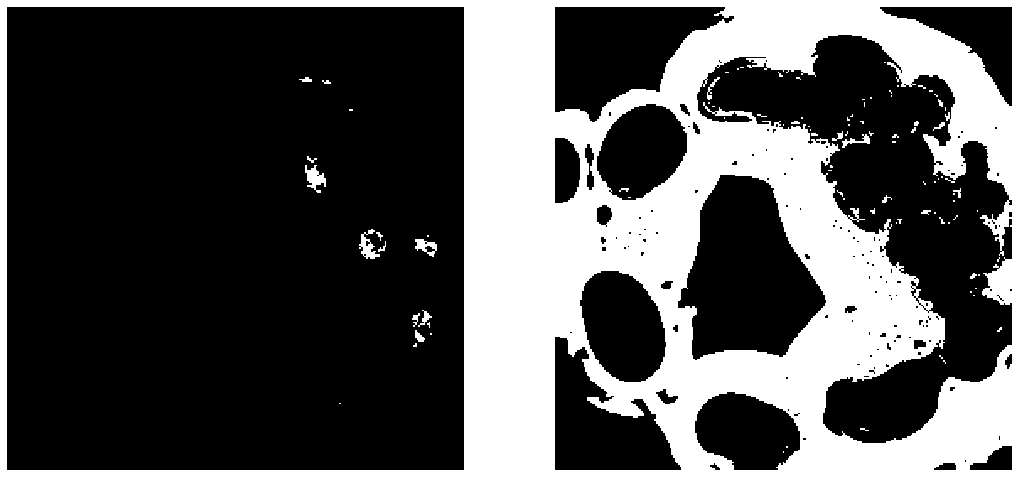

In [10]:
images = conn.getObjects('Image', opts={'dataset': dataset_id})
for image in images:
    # order zctyx
    data = load_data(image, path)
    size_c = data.shape[1]
    mid_z = numpy.int(0.5*data.shape[0])
    fig, ax = plt.subplots(1, size_c, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
    if size_c > 1:
        for channel in range(size_c):
            ax[channel].axis('off')
            ax[channel].imshow(data[mid_z, channel, 0, :, :], cmap=plt.cm.gray)
    else:
        ax.axis('off')
        ax.imshow(data[mid_z, channel, 0, :, :], cmap=plt.cm.gray)
    

### Close the connection to the OMERO server

In [10]:
conn.close()

### License
Copyright (C) 2019-2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.